# MovieLens 32M 数据探索性分析 (EDA)
本笔记本旨在通过可视化和统计分析，深入了解 MovieLens 数据集的特征，为后续召回和排序算法的设计提供依据。

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import warnings

# 忽略烦人的警告
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# 设置绘图风格
plt.style.use('ggplot')
%matplotlib inline

# 彻底解决中文字体乱码问题 (针对 macOS)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'PingFang SC', 'Heiti TC', 'sans-serif'] 
plt.rcParams['axes.unicode_minus'] = False

# 加载处理后的数据
data_dir = Path('../data/processed')
ratings = pd.read_parquet(data_dir / 'ratings.parquet')
movies = pd.read_parquet(data_dir / 'movies.parquet')

print(f'成功加载 {len(ratings):,} 条评分数据和 {len(movies):,} 条电影元数据。')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# 设置绘图风格
plt.style.use('ggplot')
%matplotlib inline

# 加载处理后的数据
data_dir = Path('../data/processed')
ratings = pd.read_parquet(data_dir / 'ratings.parquet')
movies = pd.read_parquet(data_dir / 'movies.parquet')

print(f'成功加载 {len(ratings):,} 条评分数据和 {len(movies):,} 条电影元数据。')

成功加载 32,000,204 条评分数据和 87,585 条电影元数据。


## 1. 稀疏度分析 (Sparsity Analysis)
推荐系统的核心挑战之一是数据极其稀疏。在这个单元格中，我们计算用户-物品矩阵的填充比例。
- **稀疏度** = (1 - 实际评分数 / 理论最大评分数) * 100%
- 稀疏度越高，意味着我们对用户的偏好了解越少，推荐难度越大。

In [5]:
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
actual_ratings = len(ratings)
possible_ratings = n_users * n_movies
sparsity = (1 - actual_ratings / possible_ratings) * 100

print(f'用户总数: {n_users:,}')
print(f'电影总数: {n_movies:,}')
print(f'理论最大评分组合: {possible_ratings:,}')
print(f'实际评分数量: {actual_ratings:,}')
print(f'数据集稀疏度: {sparsity:.4f}%')

用户总数: 200,948
电影总数: 84,432
理论最大评分组合: 16,966,441,536
实际评分数量: 32,000,204
数据集稀疏度: 99.8114%


## 2. 物品长尾效应分析 (Long-tail Effect)
互联网数据通常遵循幂律分布（长尾效应）。
- 我们将观察极少数的热门电影是否占据了绝大部分的评分。
- 如果长尾效应极强，热门召回（Popularity-based Recall）将是一个非常强力的基准模型。

/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

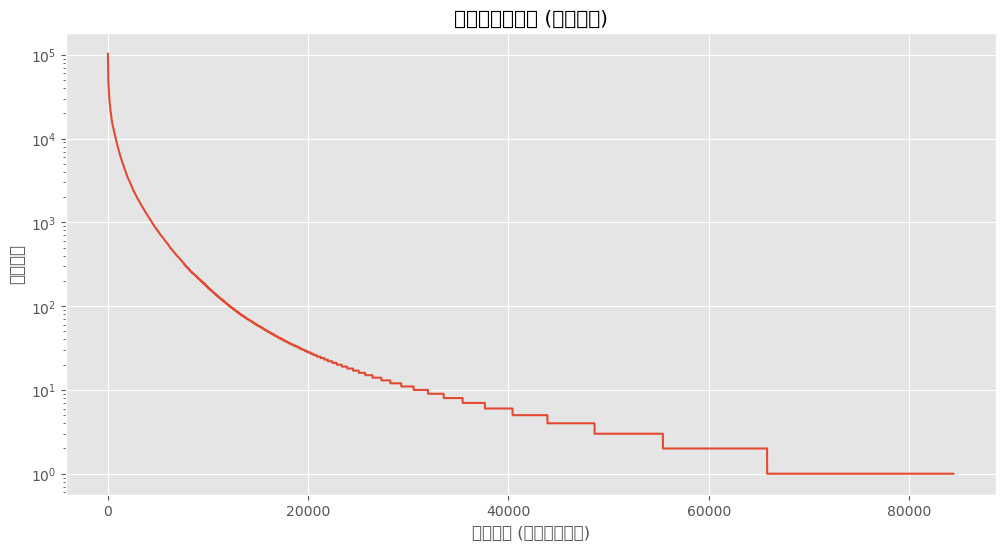

前 10% 的热门电影占据了全站 95.70% 的评分。


In [6]:
genres_exploded = movies.explode('genres')
genre_counts = genres_exploded['genres'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, hue=genre_counts.index, palette='magma', legend=False)
plt.title('电影题材分布')
plt.xlabel('电影数量')
plt.show()

# 5.1 全局评分分布
plt.figure(figsize=(10, 5))
sns.countplot(x='rating', hue='rating', data=ratings, palette='coolwarm', legend=False)
plt.title('全局评分分值分布')
plt.xlabel('评分')
plt.ylabel('数量')
plt.show()

# 5.2 用户平均评分分布
user_avg_ratings = ratings.groupby('userId')['rating'].mean()
plt.figure(figsize=(10, 5))
sns.histplot(user_avg_ratings, bins=30, kde=True, color='skyblue')
plt.title('用户平均评分分布')
plt.xlabel('平均评分')
plt.ylabel('用户数量')
plt.show()

# 5.3 电影平均评分分布 (仅考虑评分人数大于 50 的电影)
movie_stats = ratings.groupby('movieId').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['avg_rating', 'rating_count']
popular_movies_avg = movie_stats[movie_stats['rating_count'] > 50]['avg_rating']

plt.figure(figsize=(10, 5))
sns.histplot(popular_movies_avg, bins=30, kde=True, color='salmon')
plt.title('热门电影(评分数>50)平均评分分布')
plt.xlabel('平均评分')
plt.ylabel('电影数量')
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27963 (\N{CJK UNIFIED IDEOGRAPH-6D3B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36291 (\N{CJK UNIFIED IDEOGRAPH-8DC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

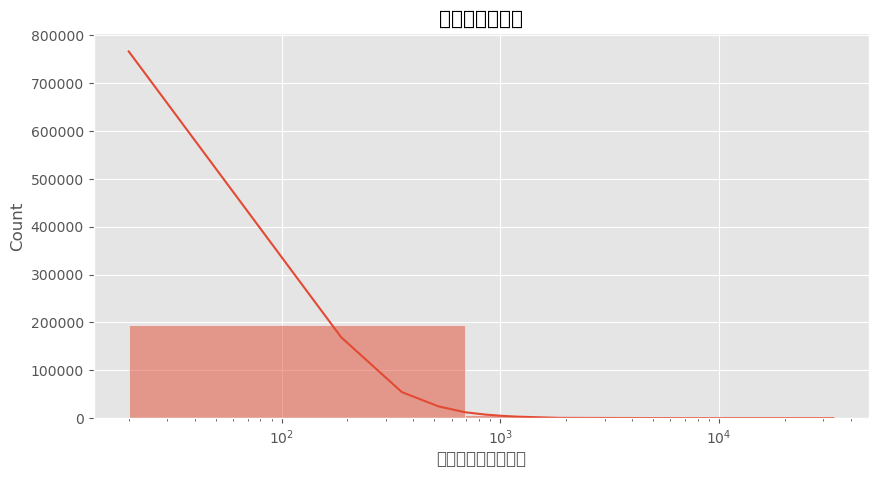

用户平均评分数: 159.2
用户评分数中位数: 73.0
最少评分数: 20
最大评分数: 33332


In [7]:
user_counts = ratings.groupby('userId').size().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.histplot(user_counts, bins=50, kde=True)
plt.title('用户活跃度分布')
plt.xlabel('每个用户的评分数量')
plt.xscale('log')
plt.show()

print(f'用户平均评分数: {user_counts.mean():.1f}')
print(f'用户评分数中位数: {user_counts.median():.1f}')
print(f'最少评分数: {user_counts.min()}')
print(f'最大评分数: {user_counts.max()}')

## 4. 电影题材分布分析
了解数据集中的题材偏好，有助于我们设计基于内容的推荐（Content-based Recommendation）。

/var/folders/bp/wvc919pd2tx89btvdsv80fbc0000gn/T/ipykernel_35197/2020133589.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='magma')
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39064 (\N{CJK UNIF

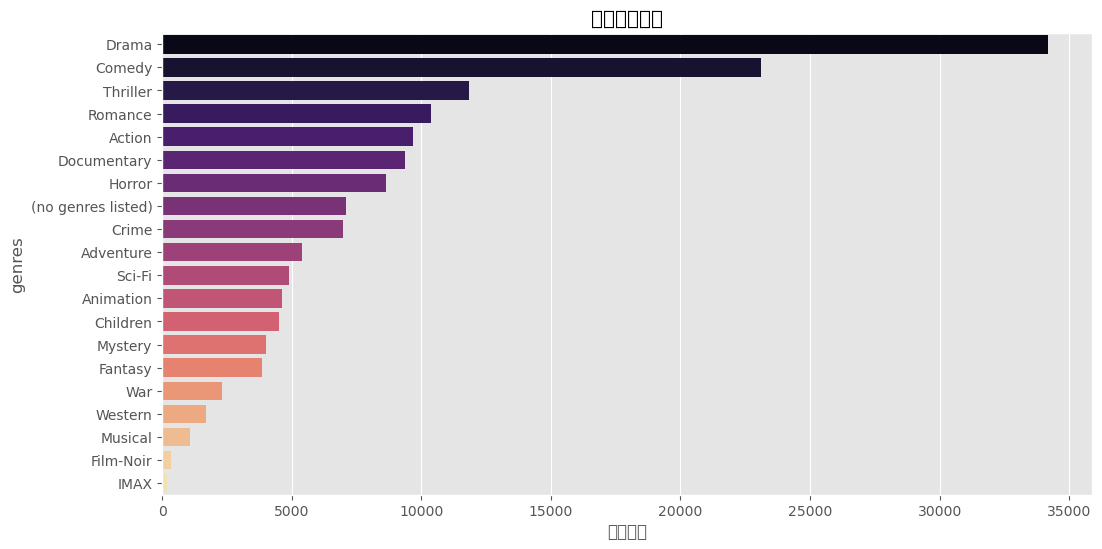

In [8]:
genres_exploded = movies.explode('genres')
genre_counts = genres_exploded['genres'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='magma')
plt.title('电影题材分布')
plt.xlabel('电影数量')
plt.show()

## 5. 评分值分布分析 (Rating Value Analysis)
了解用户打分的整体分布以及个体差异。
- **全局分布**：看看哪个分值最常见。
- **用户平均分分布**：识别“严格”用户与“宽容”用户。
- **电影平均分分布**：识别高质量电影与低质量电影。

/var/folders/bp/wvc919pd2tx89btvdsv80fbc0000gn/T/ipykernel_35197/2671759433.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='coolwarm')
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-

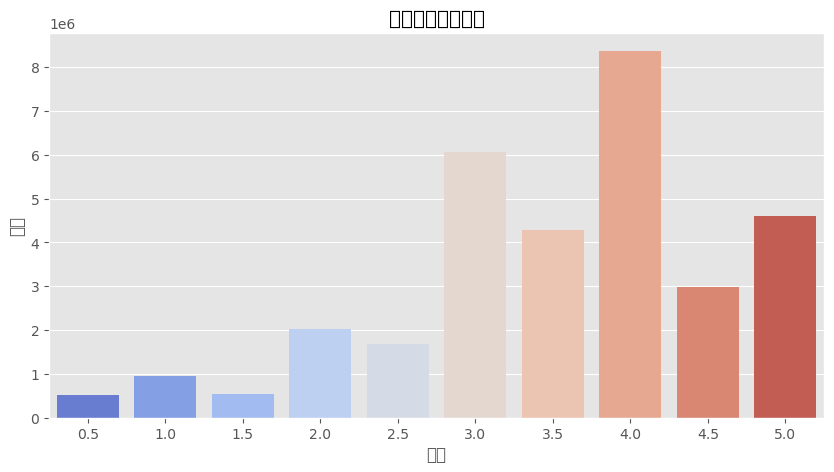

/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

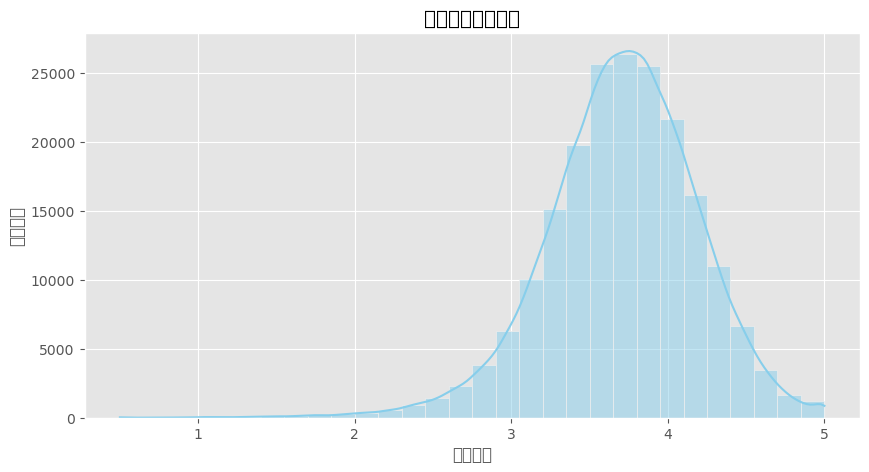

/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/movielens-rec/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

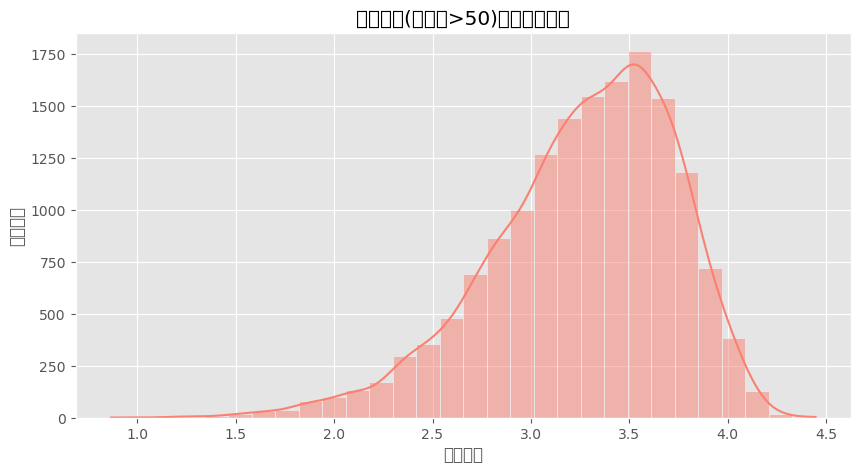

In [9]:
# 5.1 全局评分分布
plt.figure(figsize=(10, 5))
sns.countplot(x='rating', data=ratings, palette='coolwarm')
plt.title('全局评分分值分布')
plt.xlabel('评分')
plt.ylabel('数量')
plt.show()

# 5.2 用户平均评分分布
user_avg_ratings = ratings.groupby('userId')['rating'].mean()
plt.figure(figsize=(10, 5))
sns.histplot(user_avg_ratings, bins=30, kde=True, color='skyblue')
plt.title('用户平均评分分布')
plt.xlabel('平均评分')
plt.ylabel('用户数量')
plt.show()

# 5.3 电影平均评分分布 (仅考虑评分人数大于 50 的电影，避免小样本偏差)
movie_stats = ratings.groupby('movieId').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['avg_rating', 'rating_count']
popular_movies_avg = movie_stats[movie_stats['rating_count'] > 50]['avg_rating']

plt.figure(figsize=(10, 5))
sns.histplot(popular_movies_avg, bins=30, kde=True, color='salmon')
plt.title('热门电影(评分数>50)平均评分分布')
plt.xlabel('平均评分')
plt.ylabel('电影数量')
plt.show()